# Deep learning examples

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/202-NN_examples.ipynb)

This notebooks contains examples with neural network models.

**Table of contents**

* [Loading dataset](#chapter1)
* [Testing models](#chapter2)
    * [Baseline](#section_2_1)
    * [DeepAR](#section_2_2)
    * [TFT](#section_2_3)
    * [RNN](#section_2_4)
    * [MLP](#section_2_5)
    * [Deep State Model](#section_2_6)
    * [N-BEATS Model](#section_2_7)
    * [PatchTST Model](#section_2_8)
    * [Chronos Model](#section_2_9)
    * [Chronos Bolt Model](#section_2_10)
    * [TimesFM Model](#section_2_11)

In [1]:
!pip install "etna[torch,chronos,timesfm]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import random

import numpy as np
import pandas as pd
import torch

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LabelEncoderTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import StandardScalerTransform

In [4]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Let's fix seeds for reproducibility.

In [5]:
set_seed()

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

We are going to take some toy dataset. Let's load and look at it.

In [6]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the special data structure `TSDataset`. Let's create it as it was done in "Get started" notebook.

In [7]:
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Testing models <a class="anchor" id="chapter2"></a>

In this section we will test our models on example.

In [8]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

### 2.1 Baseline <a class="anchor" id="section_2_1"></a>

For comparison let's train some simple model as a baseline.

In [9]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [10]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [11]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,6.343943,6.124296,33.196532,0
0,segment_a,5.346946,5.192455,27.938101,1
0,segment_a,7.510347,7.189999,40.028565,2
1,segment_b,7.178822,6.920176,17.818102,0
1,segment_b,5.672504,5.554555,13.719200,1
1,segment_b,3.327846,3.359712,7.680919,2
2,segment_c,6.430429,6.200580,10.877718,0
2,segment_c,5.947090,5.727531,10.701336,1
2,segment_c,6.186545,5.943679,11.359563,2
3,segment_d,4.707899,4.644170,39.918646,0


In [12]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


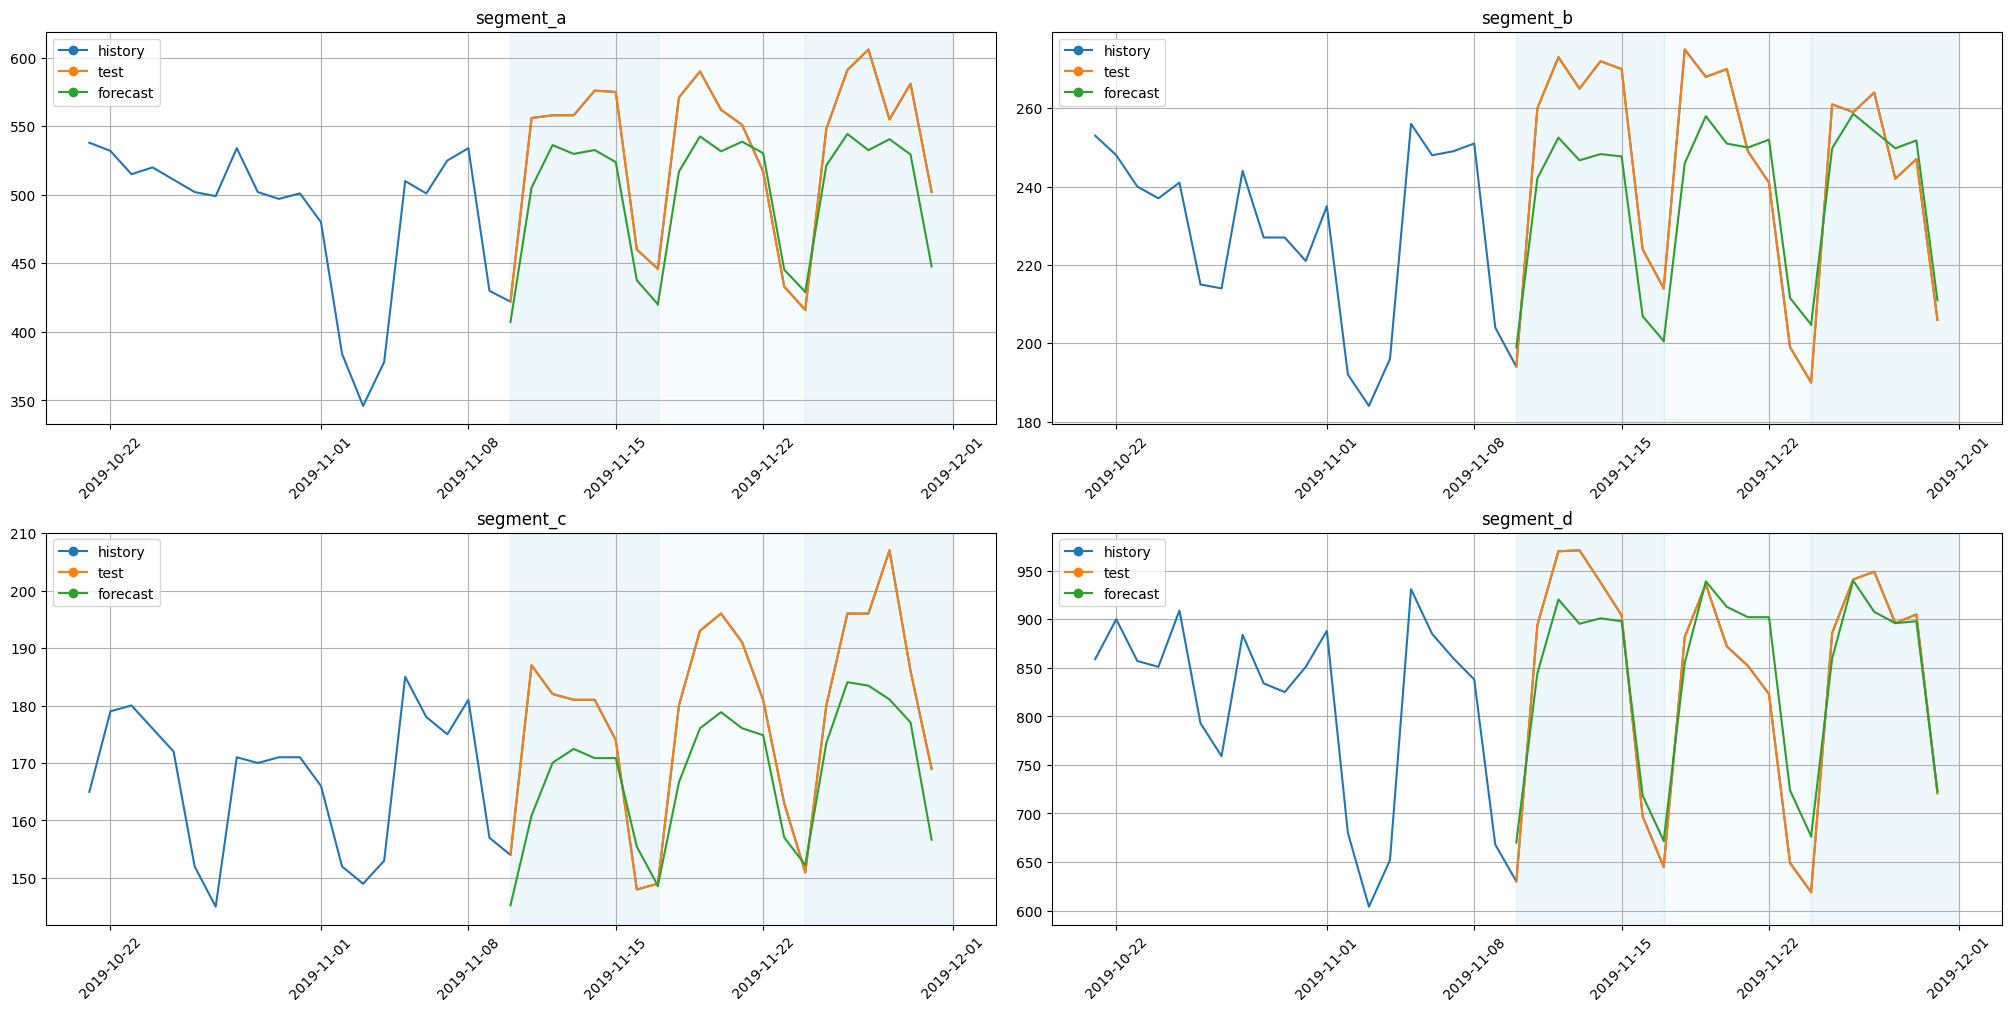

In [13]:
plot_backtest(forecast_sma, ts, history_len=20)

### 2.2 DeepAR <a class="anchor" id="section_2_2"></a>

Note that the original `DeepARModel` was removed in version `3.0`. `DeepARNativeModel` to renamed to `DeepARModel`.

In [14]:
from etna.models.nn import DeepARModel

In [15]:
num_lags = 7

scaler = StandardScalerTransform(in_column="target")
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    day_number_in_year=False,
    week_number_in_month=False,
    week_number_in_year=False,
    month_number_in_year=False,
    season_number=False,
    year_number=False,
    is_weekend=False,
    out_column="dateflag",
)
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

embedding_sizes = {"dateflag_day_number_in_week_label": (7, 7)}

In [16]:
set_seed()

model_deepar = DeepARModel(
    input_size=num_lags + 1,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    embedding_sizes=embedding_sizes,
    lr=0.01,
    scale=False,
    n_samples=100,
    trainer_params=dict(max_epochs=2),
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[scaler, transform_lag, transform_date, label_encoder],
)

In [17]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | loss       | GaussianLoss   | 0      | train
1 | embedding  | MultiEmbedding | 56     | train
2 | rnn        | LSTM           | 4.3 K  | train
3 | projection | ModuleDict     | 34     | train
------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=2` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | loss       | GaussianLoss   | 0      | train
1 | embedding  | MultiEmbedding | 56     | train
2 | rnn        | LSTM           | 4.3 K  | train
3 | projection | ModuleDict     | 34     | train
------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=2` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.9s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | loss       | GaussianLoss   | 0      | train
1 | embedding  | MultiEmbedding | 56     | train
2 | rnn        | LSTM           | 4.3 K  | train
3 | projection | ModuleDict     | 34     | train
------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=2` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [18]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 5.816


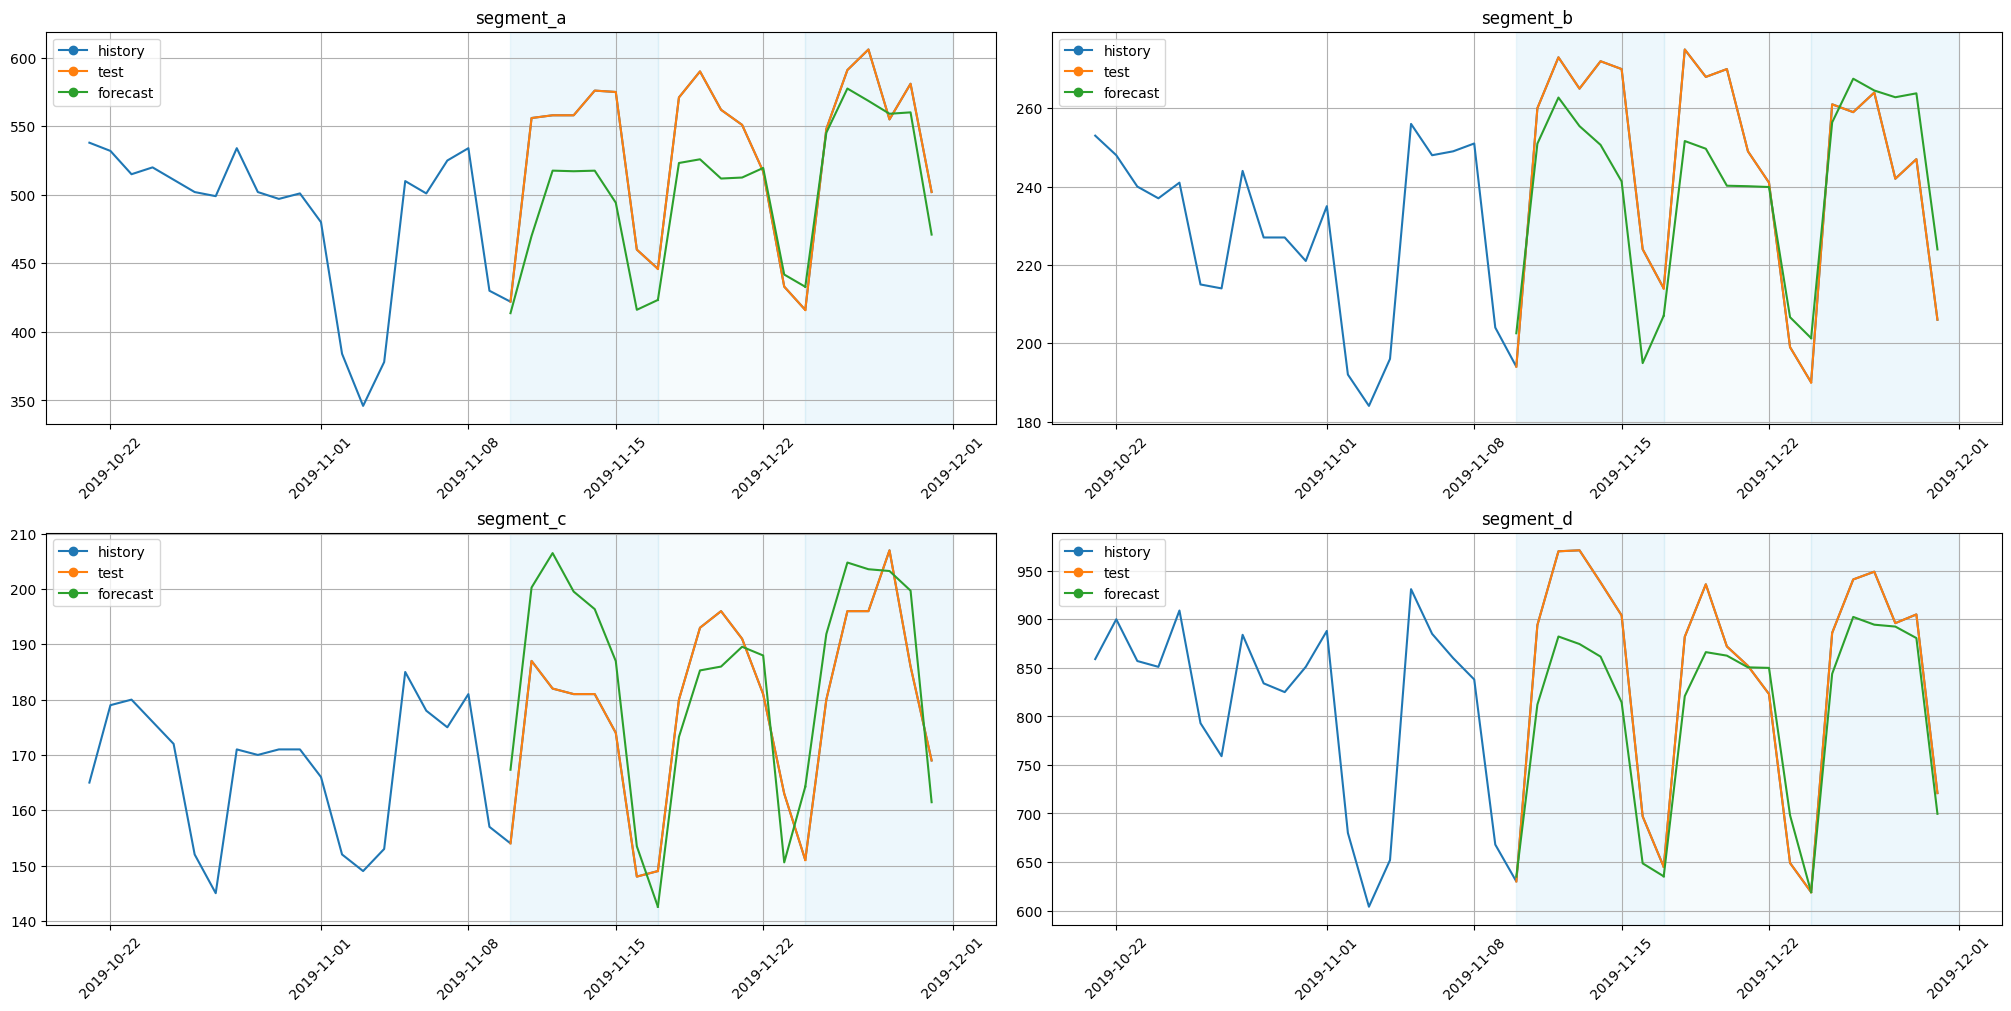

In [19]:
plot_backtest(forecast_deepar, ts, history_len=20)

### 2.3 TFT <a class="anchor" id="section_2_3"></a>

Note that the original `TFTModel` was removed in version `3.0`. `TFTNativeModel` to renamed to `TFTModel`.

In [20]:
from etna.models.nn import TFTModel

In [21]:
num_lags = 7
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    day_number_in_year=False,
    week_number_in_month=False,
    week_number_in_year=False,
    month_number_in_year=False,
    season_number=False,
    year_number=False,
    is_weekend=False,
    out_column="dateflag",
)
scaler = StandardScalerTransform(in_column=["target"])

encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

In [22]:
set_seed()

model_tft = TFTModel(
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    static_categoricals=["segment_code"],
    time_varying_categoricals_encoder=["dateflag_day_number_in_week_label"],
    time_varying_categoricals_decoder=["dateflag_day_number_in_week_label"],
    time_varying_reals_encoder=["target"] + lag_columns,
    time_varying_reals_decoder=lag_columns,
    num_embeddings={"segment_code": len(ts.segments), "dateflag_day_number_in_week_label": 7},
    n_heads=1,
    num_layers=2,
    hidden_size=32,
    lr=0.0001,
    train_batch_size=16,
    trainer_params=dict(max_epochs=5, gradient_clip_val=0.1),
)
pipeline_tft = Pipeline(
    model=model_tft, horizon=HORIZON, transforms=[transform_lag, scaler, transform_date, encoder, label_encoder]
)

In [23]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                            | Type                     | Params | Mode 
--------------------------------------------------------------------------------------
0  | loss                            | MSELoss                  | 0      | train
1  | static_scalers                  | ModuleDict               | 0      | train
2  | static_embeddings               | ModuleDict               | 160    | train
3  | time_varying_scalers_encoder    | ModuleDict               | 512    | train
4  | time_varying_embeddings_encoder | ModuleDict               | 256    | train
5  | time_varying_scalers_decoder    | ModuleDict               | 448    | train
6  | time_varying_embeddings_decoder | ModuleDict               | 256    | train
7  | static_variable_selection       | VariableSelectionNetwork | 6.5 K  | train
8  | encoder_variable_selection      | VariableSelectionNetwork | 2

Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    9.2s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                            | Type                     | Params | Mode 
--------------------------------------------------------------------------------------
0  | loss                            | MSELoss                  | 0      | train
1  | static_scalers                  | ModuleDict               | 0      | train
2  | static_embeddings               | ModuleDict               | 160    | train
3  | time_varying_scalers_encoder    | ModuleDict               | 512    | train
4  | time_varying_embeddings_encoder | ModuleDict               | 256    | train
5  | time_varying_scalers_decoder    | ModuleDict               | 448    | train
6  | time_varying_embeddings_decoder | ModuleDict               | 256    | train
7  | static_variable_selection       | V

Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   19.8s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                            | Type                     | Params | Mode 
--------------------------------------------------------------------------------------
0  | loss                            | MSELoss                  | 0      | train
1  | static_scalers                  | ModuleDict               | 0      | train
2  | static_embeddings               | ModuleDict               | 160    | train
3  | time_varying_scalers_encoder    | ModuleDict               | 512    | train
4  | time_varying_embeddings_encoder | ModuleDict               | 256    | train
5  | time_varying_scalers_decoder    | ModuleDict               | 448    | train
6  | time_varying_embeddings_decoder | ModuleDict               | 256    | train
7  | static_variable_selection       | V

Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   29.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   29.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [24]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 7.013


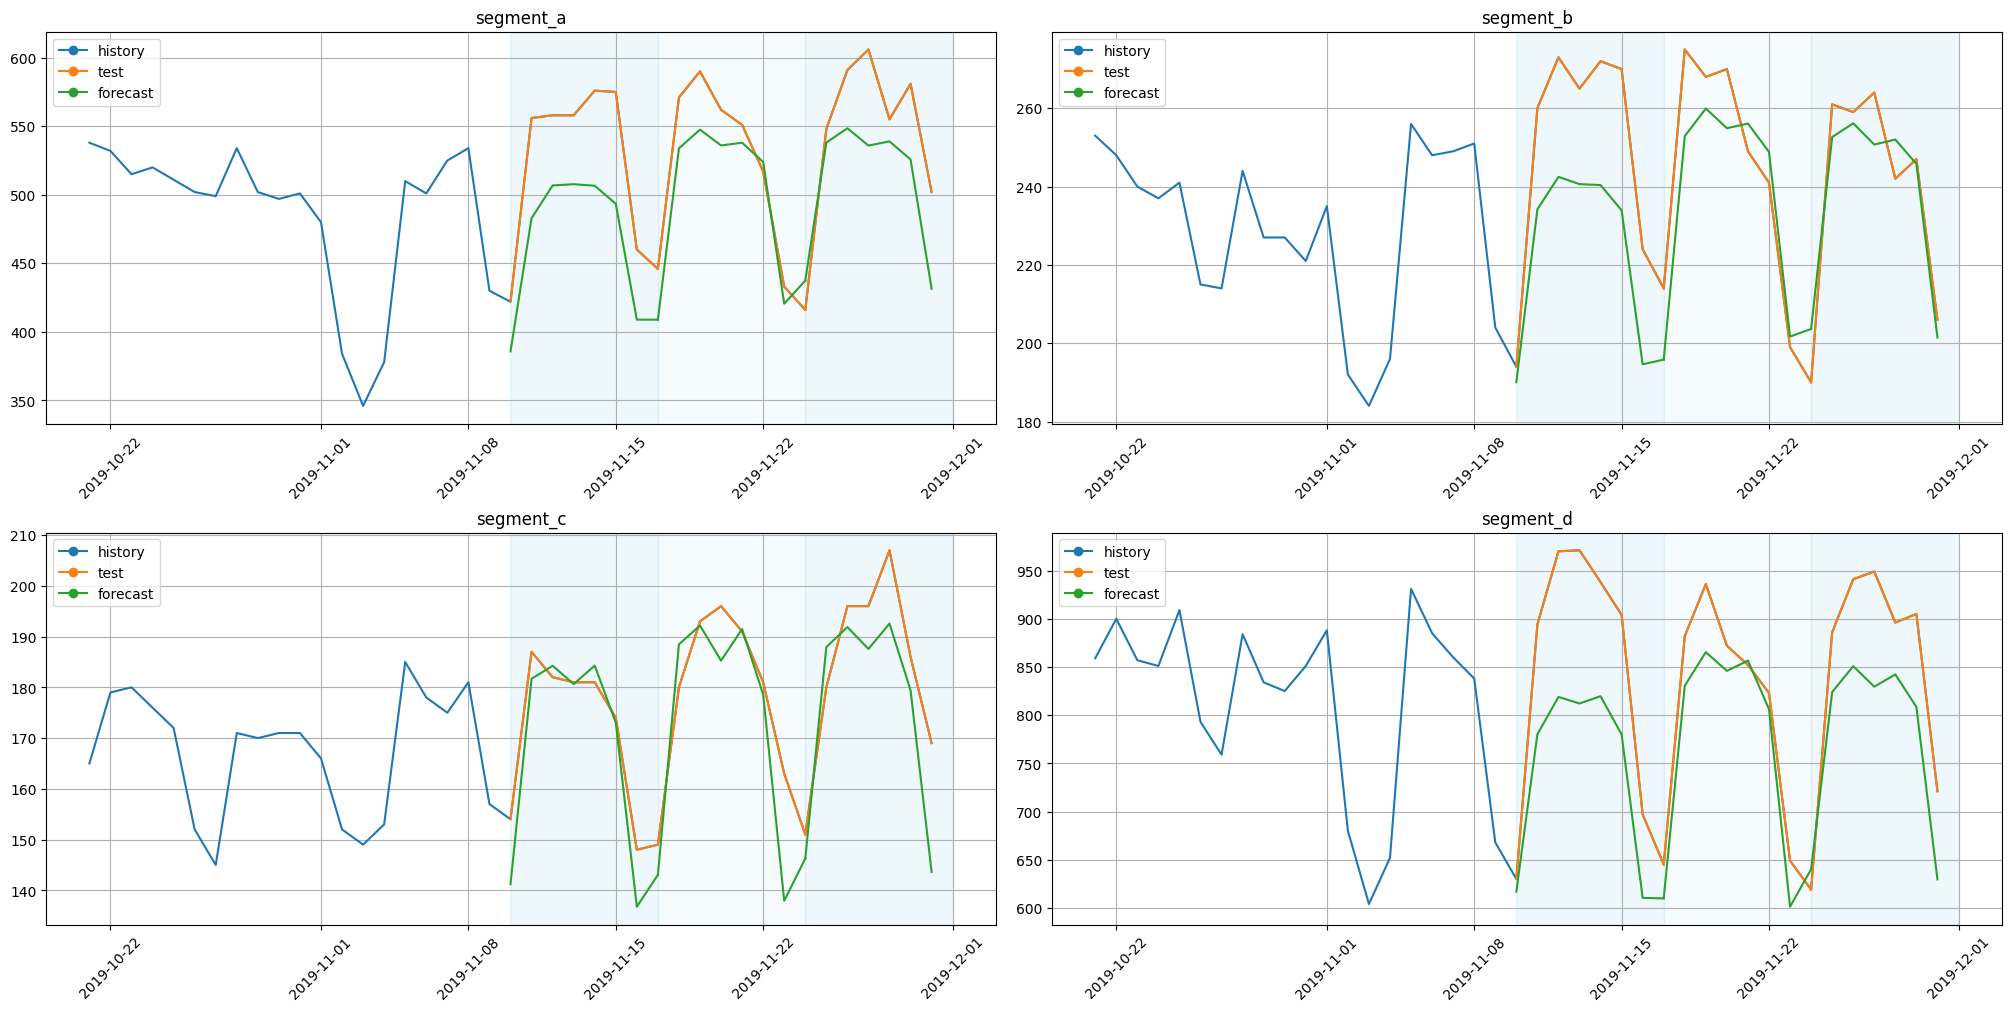

In [25]:
plot_backtest(forecast_tft, ts, history_len=20)

### 2.4 RNN <a class="anchor" id="section_2_4"></a>

We'll use RNN model based on LSTM cell

In [26]:
from etna.models.nn import RNNModel

In [27]:
num_lags = 7

scaler = StandardScalerTransform(in_column="target")
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    day_number_in_year=False,
    week_number_in_month=False,
    week_number_in_year=False,
    month_number_in_year=False,
    season_number=False,
    year_number=False,
    is_weekend=False,
    out_column="dateflag",
)
segment_encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

embedding_sizes = {"dateflag_day_number_in_week_label": (7, 7)}

In [28]:
set_seed()

model_rnn = RNNModel(
    input_size=num_lags + 1,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    embedding_sizes=embedding_sizes,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[scaler, transform_lag, transform_date, label_encoder],
)

In [29]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | loss       | MSELoss        | 0      | train
1 | embedding  | MultiEmbedding | 56     | train
2 | rnn        | LSTM           | 4.3 K  | train
3 | projection | Linear         | 17     | train
------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | loss       | MSELoss        | 0      | train
1 | embedding  | MultiEmbedding | 56     | train
2 | rnn        | LSTM           | 4.3 K  | train
3 | projection | Linear         | 17     | train
------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.8s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | loss       | MSELoss        | 0      | train
1 | embedding  | MultiEmbedding | 56     | train
2 | rnn        | LSTM           | 4.3 K  | train
3 | projection | Linear         | 17     | train
------------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [30]:
score = metrics_rnn["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 5.653


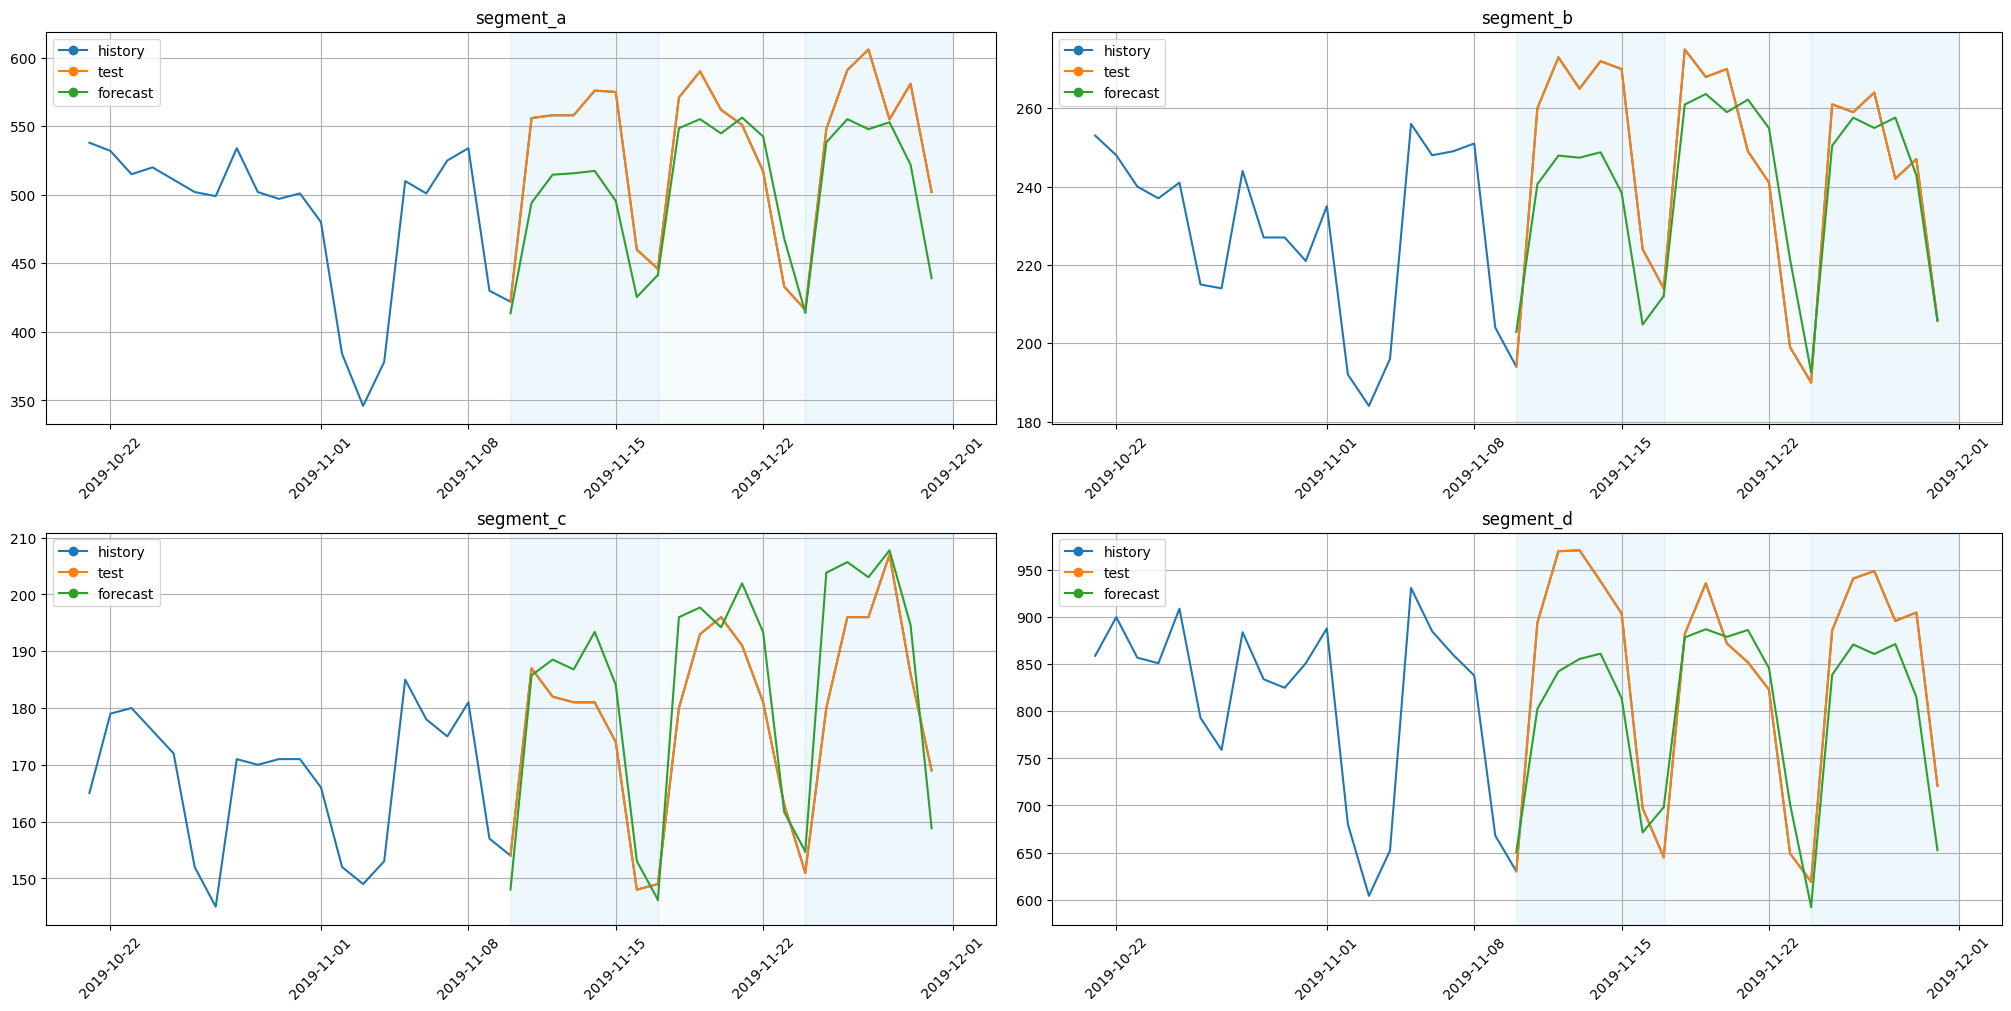

In [31]:
plot_backtest(forecast_rnn, ts, history_len=20)

### 2.5 MLP <a class="anchor" id="section_2_5"></a>

Base model with linear layers and activations.

In [32]:
from etna.models.nn import MLPModel

In [33]:
num_lags = 14

transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    day_number_in_year=False,
    week_number_in_month=False,
    week_number_in_year=False,
    month_number_in_year=False,
    season_number=False,
    year_number=False,
    is_weekend=False,
    out_column="dateflag",
)
segment_encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

embedding_sizes = {"dateflag_day_number_in_week_label": (7, 7)}

In [34]:
set_seed()

model_mlp = MLPModel(
    input_size=num_lags,
    hidden_size=[16],
    embedding_sizes=embedding_sizes,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=50, gradient_clip_val=0.1),
    lr=0.001,
    train_batch_size=16,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_mlp = Pipeline(model=model_mlp, transforms=[transform_lag, transform_date, label_encoder], horizon=HORIZON)

In [35]:
metrics_mlp, forecast_mlp, fold_info_mlp = pipeline_mlp.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | loss      | MSELoss        | 0      | train
1 | embedding | MultiEmbedding | 56     | train
2 | mlp       | Sequential     | 369    | train
-----------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=50` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | loss      | MSELoss        | 0      | train
1 | embedding | MultiEmbedding | 56     | train
2 | mlp       | Sequential     | 369    | train
-----------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=50` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.7s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | loss      | MSELoss        | 0      | train
1 | embedding | MultiEmbedding | 56     | train
2 | mlp       | Sequential     | 369    | train
-----------------------------------------------------
425       Trainable params
0         Non-trainable params
425       Total params
0.002     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=50` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [36]:
score = metrics_mlp["SMAPE"].mean()
print(f"Average SMAPE for MLP: {score:.3f}")

Average SMAPE for MLP: 5.861


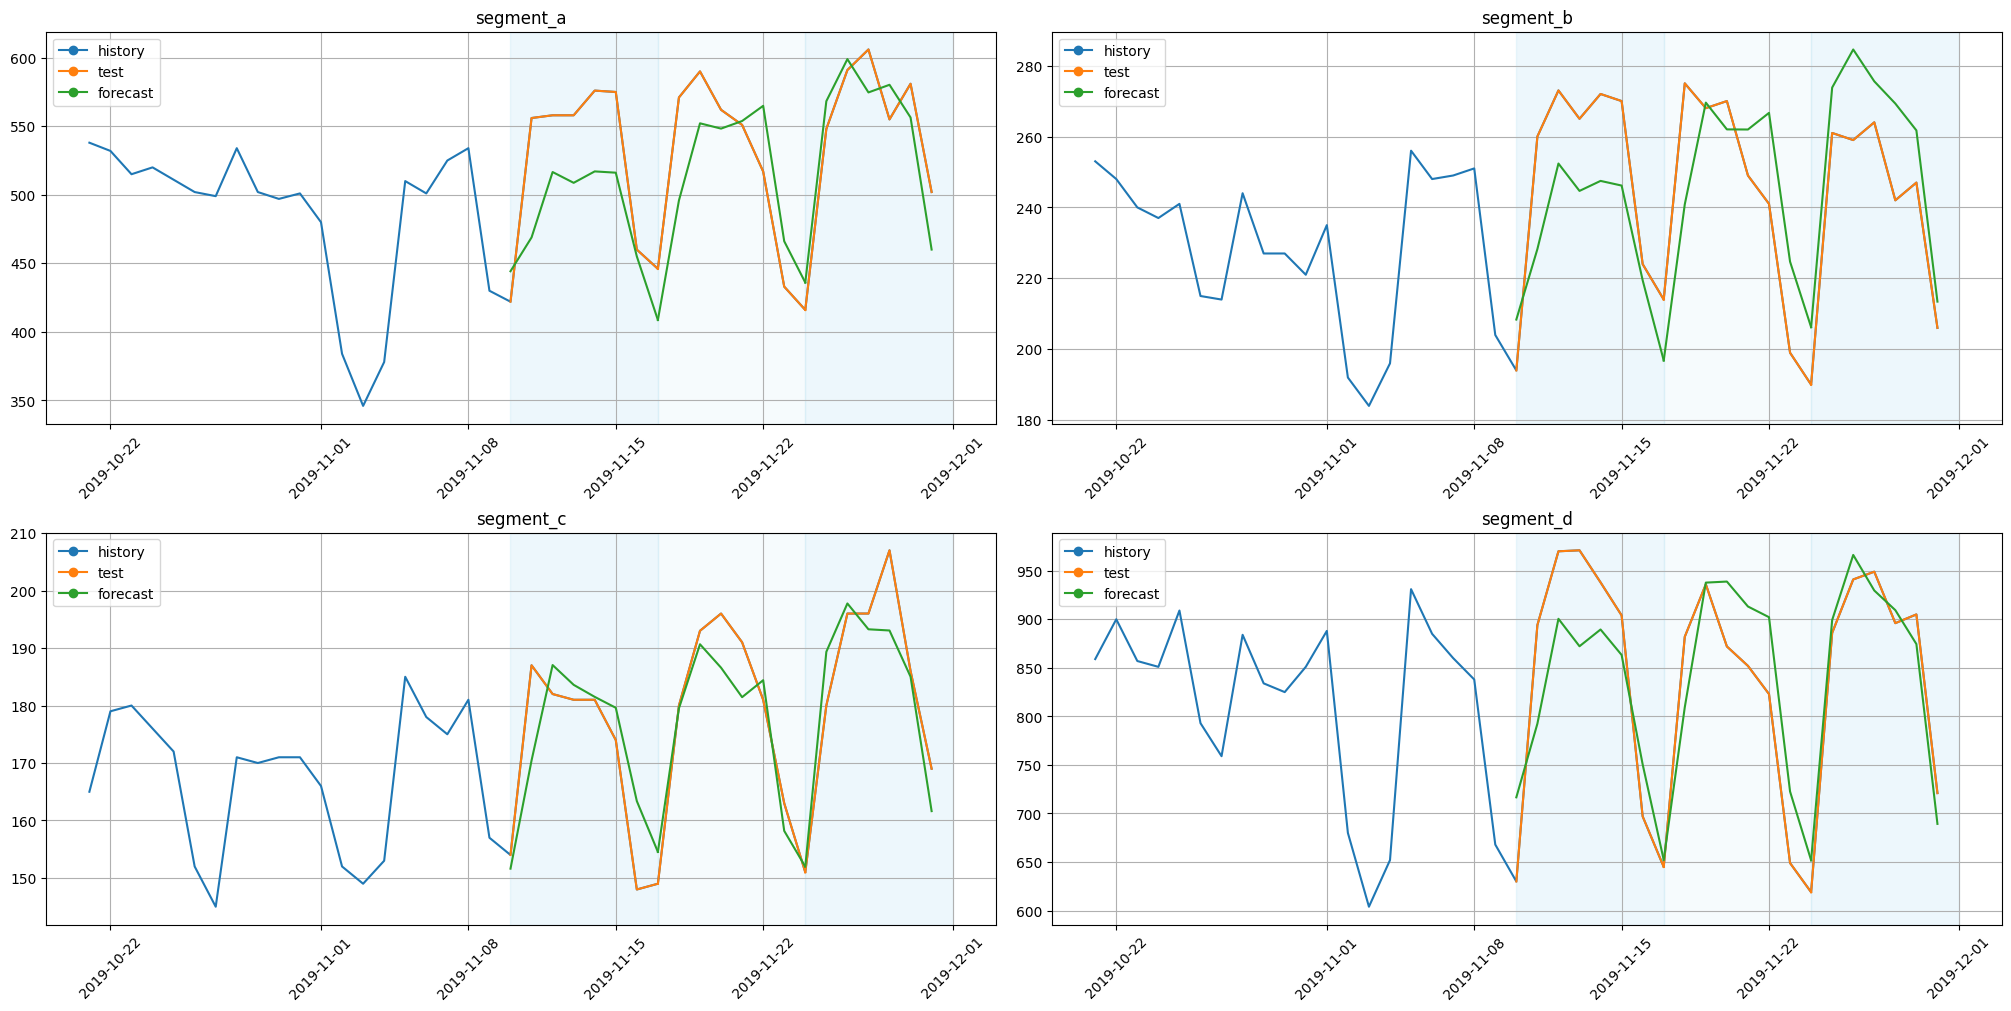

In [37]:
plot_backtest(forecast_mlp, ts, history_len=20)

### 2.6 Deep State Model <a class="anchor" id="section_2_6"></a>

`Deep State Model` works well with multiple similar time-series. It inffers shared patterns from them.

We have to determine the type of seasonality in data (based on data granularity), `SeasonalitySSM` class is responsible for this. In this example, we have daily data, so we use day-of-week (7 seasons) and day-of-month (31 seasons) models. We also set the trend component using the `LevelTrendSSM` class. Also in the model we use time-based features like day-of-week, day-of-month and time independent feature representing the segment of time series.

In [38]:
from etna.models.nn import DeepStateModel
from etna.models.nn.deepstate import CompositeSSM
from etna.models.nn.deepstate import LevelTrendSSM
from etna.models.nn.deepstate import SeasonalitySSM

In [39]:
from etna.transforms import FilterFeaturesTransform

In [40]:
num_lags = 7

transforms = [
    SegmentEncoderTransform(),
    StandardScalerTransform(in_column="target"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        day_number_in_year=False,
        week_number_in_month=False,
        week_number_in_year=False,
        month_number_in_year=False,
        season_number=False,
        year_number=False,
        is_weekend=False,
        out_column="dateflag",
    ),
    LagTransform(
        in_column="target",
        lags=[HORIZON + i for i in range(num_lags)],
        out_column="target_lag",
    ),
    LabelEncoderTransform(
        in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
    ),
    LabelEncoderTransform(
        in_column="dateflag_day_number_in_month", strategy="none", out_column="dateflag_day_number_in_month_label"
    ),
    FilterFeaturesTransform(exclude=["dateflag_day_number_in_week", "dateflag_day_number_in_month"]),
]


embedding_sizes = {
    "dateflag_day_number_in_week_label": (7, 7),
    "dateflag_day_number_in_month_label": (31, 7),
    "segment_code": (4, 7),
}

In [41]:
monthly_smm = SeasonalitySSM(num_seasons=31, timestamp_transform=lambda x: x.day - 1)
weekly_smm = SeasonalitySSM(num_seasons=7, timestamp_transform=lambda x: x.weekday())

In [42]:
set_seed()

model_dsm = DeepStateModel(
    ssm=CompositeSSM(seasonal_ssms=[weekly_smm, monthly_smm], nonseasonal_ssm=LevelTrendSSM()),
    input_size=num_lags,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    embedding_sizes=embedding_sizes,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_dsm = Pipeline(
    model=model_dsm,
    horizon=HORIZON,
    transforms=transforms,
)

In [43]:
metrics_dsm, forecast_dsm, fold_info_dsm = pipeline_dsm.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | embedding  | MultiEmbedding | 315    | train
1 | RNN        | LSTM           | 11.2 K | train
2 | projectors | ModuleDict     | 5.0 K  | train
------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.9s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | embedding  | MultiEmbedding | 315    | train
1 | RNN        | LSTM           | 11.2 K | train
2 | projectors | ModuleDict     | 5.0 K  | train
------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   13.8s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | embedding  | MultiEmbedding | 315    | train
1 | RNN        | LSTM           | 11.2 K | train
2 | projectors | ModuleDict     | 5.0 K  | train
------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   20.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   20.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [44]:
score = metrics_dsm["SMAPE"].mean()
print(f"Average SMAPE for DeepStateModel: {score:.3f}")

Average SMAPE for DeepStateModel: 5.520


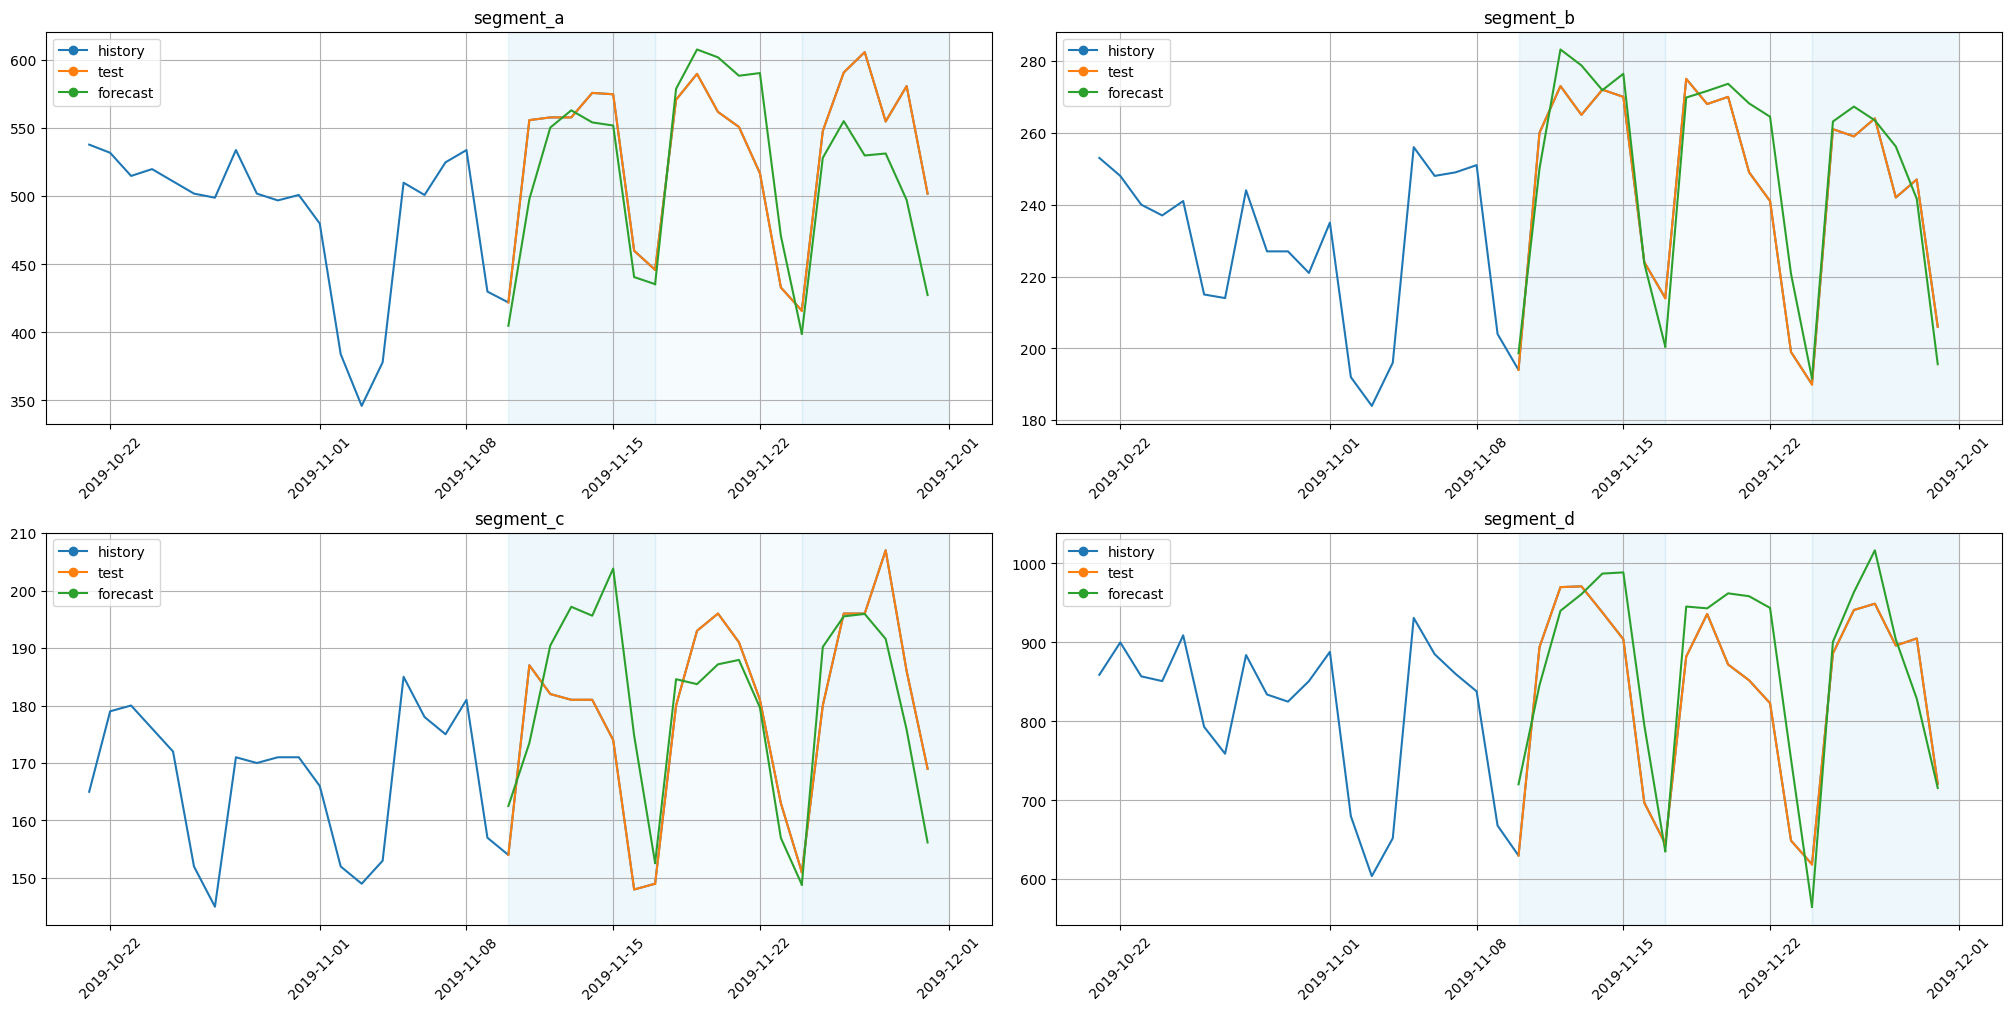

In [45]:
plot_backtest(forecast_dsm, ts, history_len=20)

### 2.7 N-BEATS Model <a class="anchor" id="section_2_7"></a>

This architecture is based on backward and forward residual links and a deep stack of fully connected layers.

There are two types of models in the library. The `NBeatsGenericModel` class implements a generic deep learning model, while the `NBeatsInterpretableModel` is augmented with certain inductive biases to be interpretable (trend and seasonality).

In [46]:
from etna.models.nn import NBeatsGenericModel
from etna.models.nn import NBeatsInterpretableModel

In [47]:
set_seed()

model_nbeats_generic = NBeatsGenericModel(
    input_size=2 * HORIZON,
    output_size=HORIZON,
    loss="smape",
    stacks=30,
    layers=4,
    layer_size=256,
    trainer_params=dict(max_epochs=1000),
    lr=1e-3,
)

pipeline_nbeats_generic = Pipeline(
    model=model_nbeats_generic,
    horizon=HORIZON,
    transforms=[],
)

In [48]:
metrics_nbeats_generic, forecast_nbeats_generic, _ = pipeline_nbeats_generic.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | NBeats      | 206 K  | train
1 | loss  | NBeatsSMAPE | 0      | train
----------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   28.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | NBeats      | 206 K  | train
1 | loss  | NBeatsSMAPE | 0      | train
----------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.1min
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | NBeats      | 206 K  | train
1 | loss  | NBeatsSMAPE | 0      | train
----------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [49]:
score = metrics_nbeats_generic["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Generic: {score:.3f}")

Average SMAPE for N-BEATS Generic: 6.050


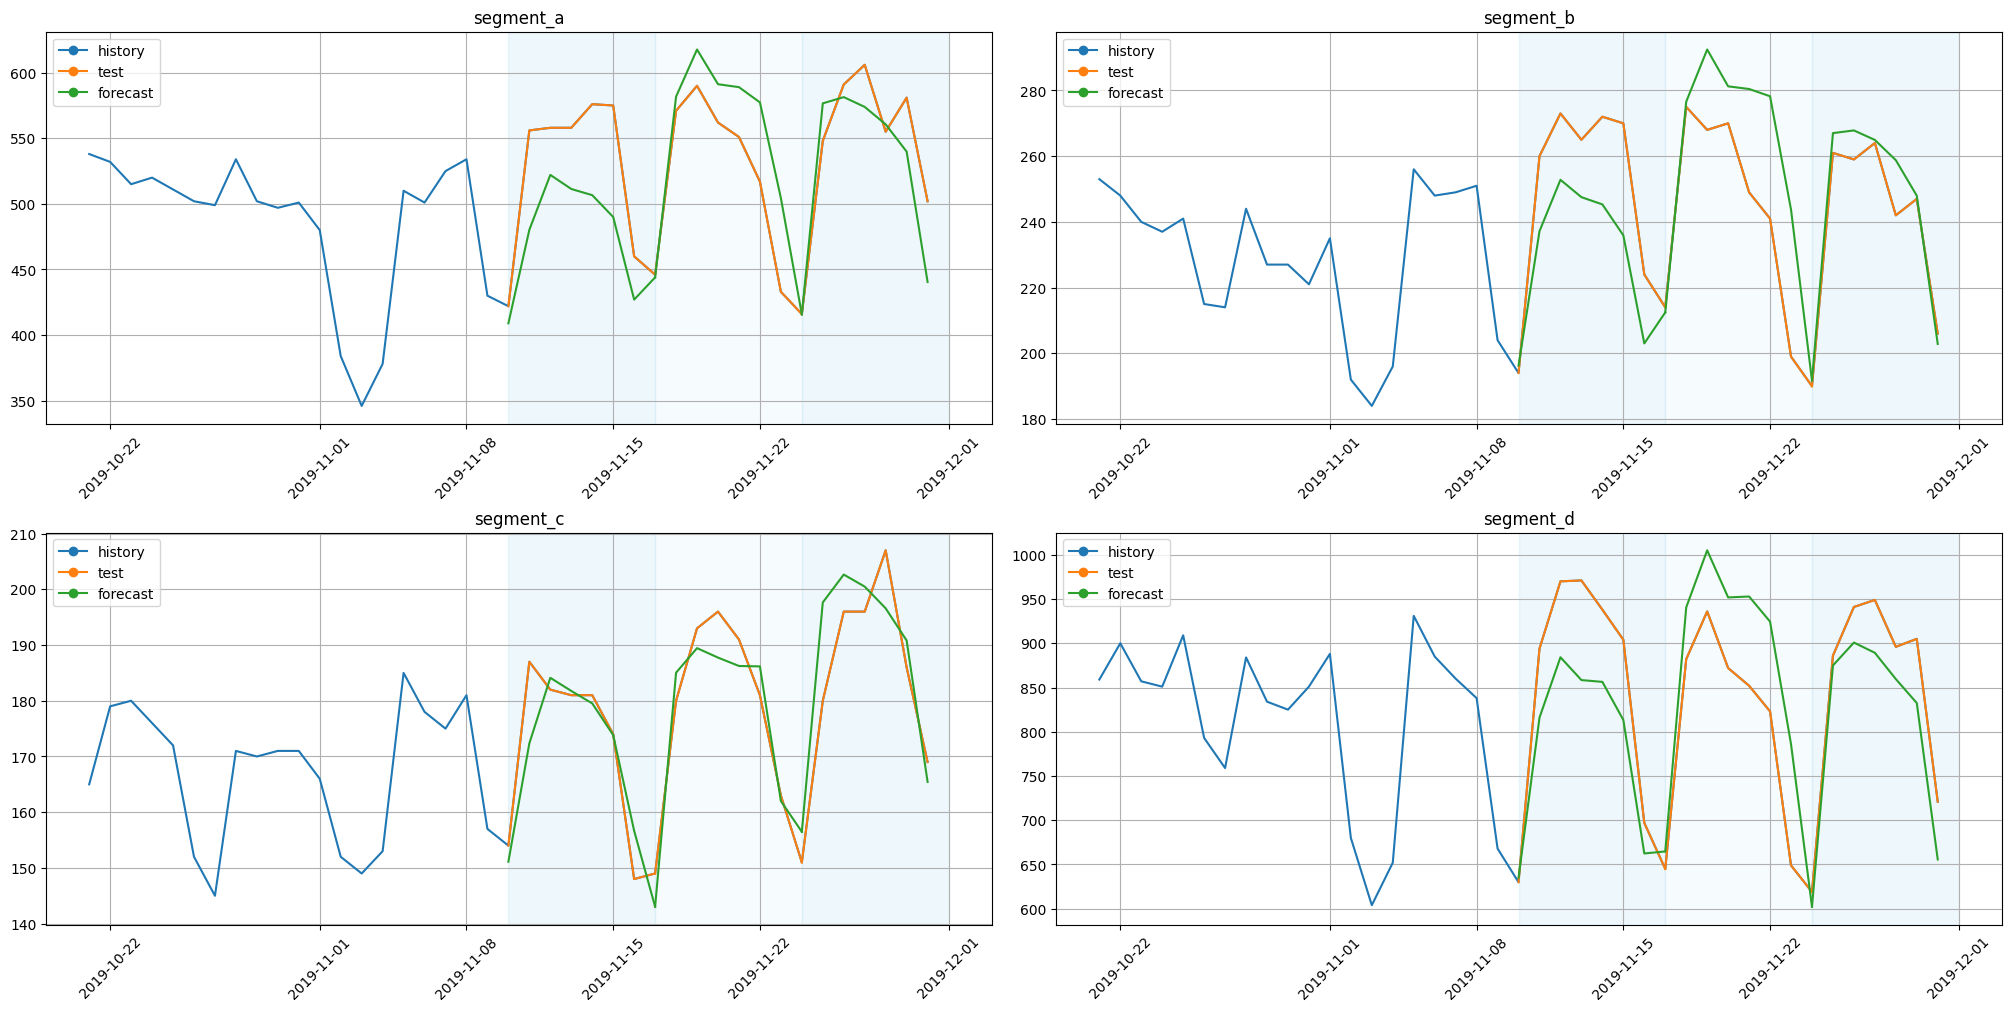

In [50]:
plot_backtest(forecast_nbeats_generic, ts, history_len=20)

In [51]:
model_nbeats_interp = NBeatsInterpretableModel(
    input_size=4 * HORIZON,
    output_size=HORIZON,
    loss="smape",
    trend_layer_size=64,
    seasonality_layer_size=256,
    trainer_params=dict(max_epochs=2000),
    lr=1e-3,
)

pipeline_nbeats_interp = Pipeline(
    model=model_nbeats_interp,
    horizon=HORIZON,
    transforms=[],
)

In [52]:
metrics_nbeats_interp, forecast_nbeats_interp, _ = pipeline_nbeats_interp.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | NBeats      | 224 K  | train
1 | loss  | NBeatsSMAPE | 0      | train
----------------------------------------------
223 K     Trainable params
385       Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=2000` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   42.5s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | NBeats      | 224 K  | train
1 | loss  | NBeatsSMAPE | 0      | train
----------------------------------------------
223 K     Trainable params
385       Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=2000` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.4min
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | NBeats      | 224 K  | train
1 | loss  | NBeatsSMAPE | 0      | train
----------------------------------------------
223 K     Trainable params
385       Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=2000` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [53]:
score = metrics_nbeats_interp["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Interpretable: {score:.3f}")

Average SMAPE for N-BEATS Interpretable: 5.693


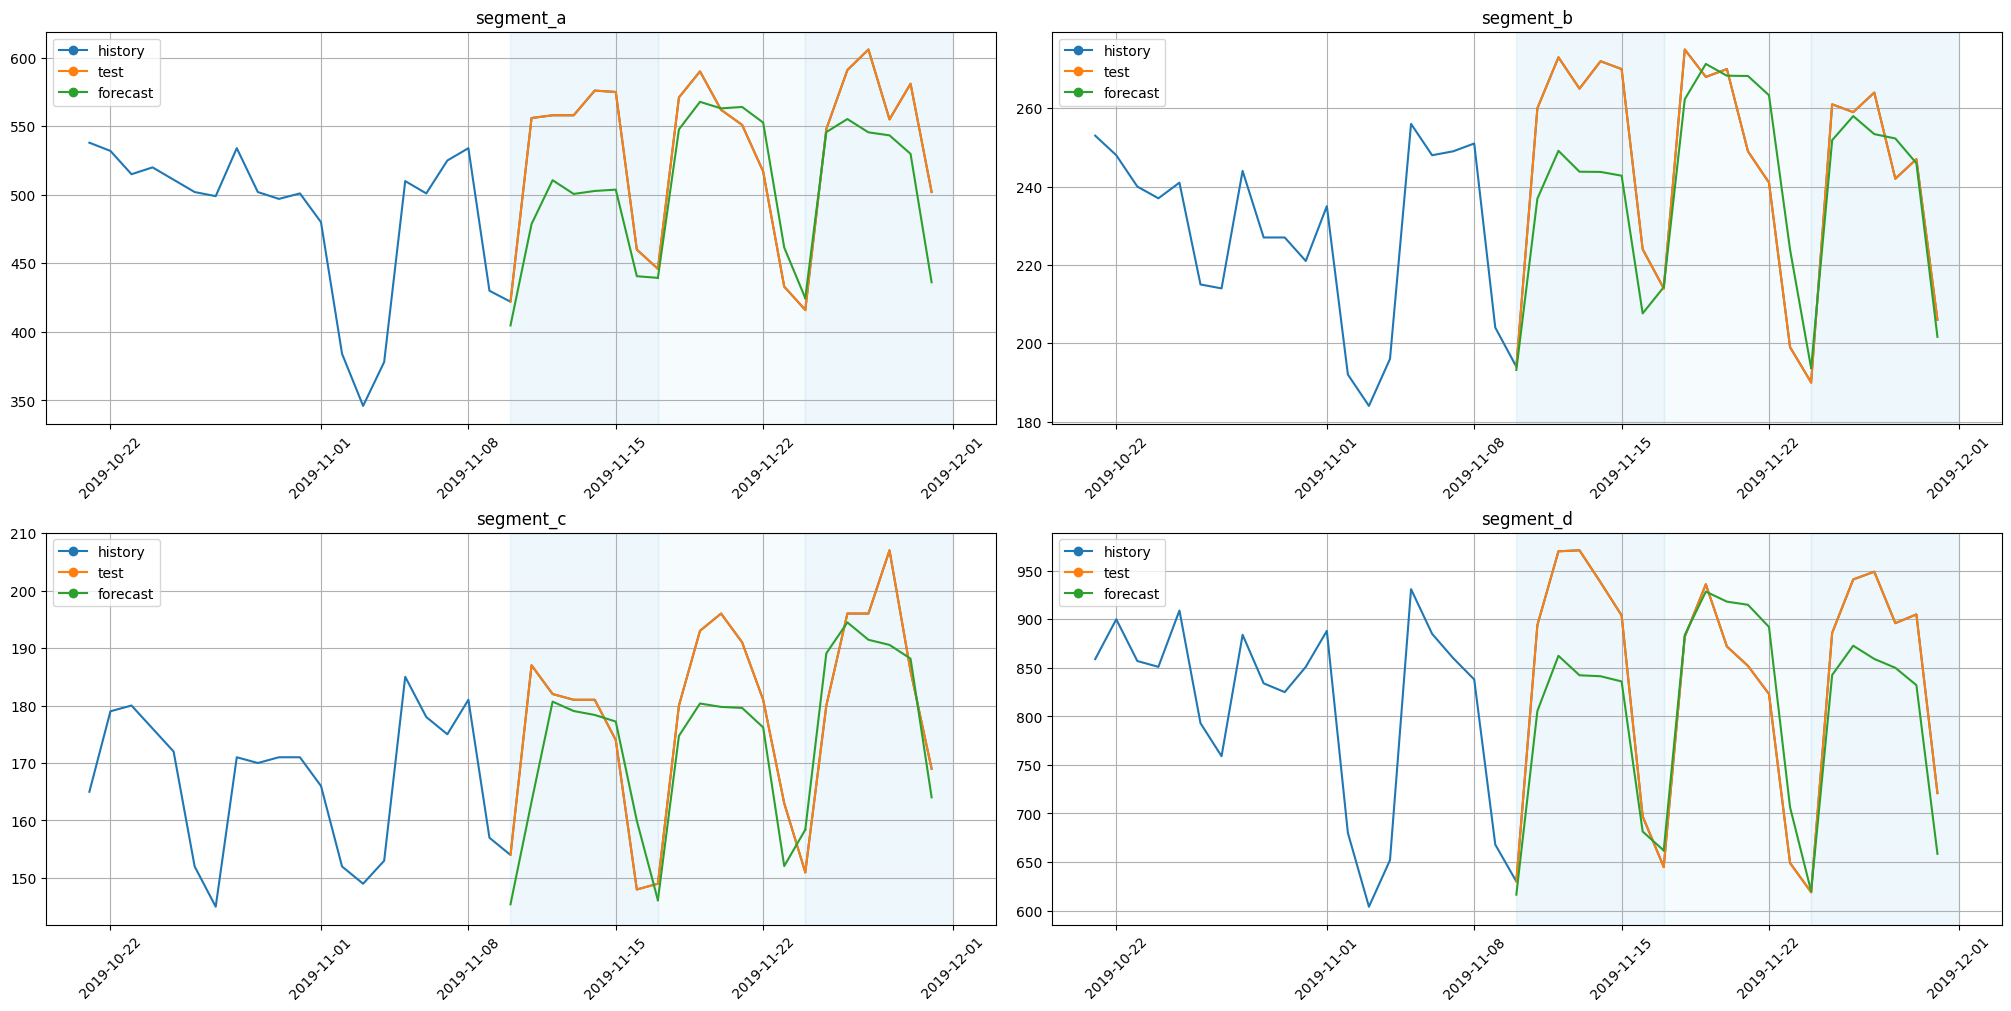

In [54]:
plot_backtest(forecast_nbeats_interp, ts, history_len=20)

### 2.8 PatchTST Model <a class="anchor" id="section_2_8"></a>

Model with transformer encoder that uses patches of timeseries as input words and linear decoder.

In [55]:
from etna.models.nn import PatchTSTModel

In [56]:
set_seed()

model_patchtst = PatchTSTModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    patch_len=1,
    trainer_params=dict(max_epochs=30),
    lr=1e-3,
    train_batch_size=64,
)

pipeline_patchtst = Pipeline(
    model=model_patchtst, horizon=HORIZON, transforms=[StandardScalerTransform(in_column="target")]
)

metrics_patchtst, forecast_patchtst, fold_info_patchtst = pipeline_patchtst.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | loss       | MSELoss    | 0      | train
1 | model      | Sequential | 397 K  | train
2 | projection | Sequential | 1.8 K  | train
--------------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.2min
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | loss       | MSELoss    | 0      | train
1 | model      | Sequential | 397 K  | train
2 | projection | Sequential | 1.8 K  | train
--------------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.4min
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | loss       | MSELoss    | 0      | train
1 | model      | Sequential | 397 K  | train
2 | projection | Sequential | 1.8 K  | train
--------------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Training: |                                                                                        | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.5min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.5min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [57]:
score = metrics_patchtst["SMAPE"].mean()
print(f"Average SMAPE for PatchTST: {score:.3f}")

Average SMAPE for PatchTST: 6.461


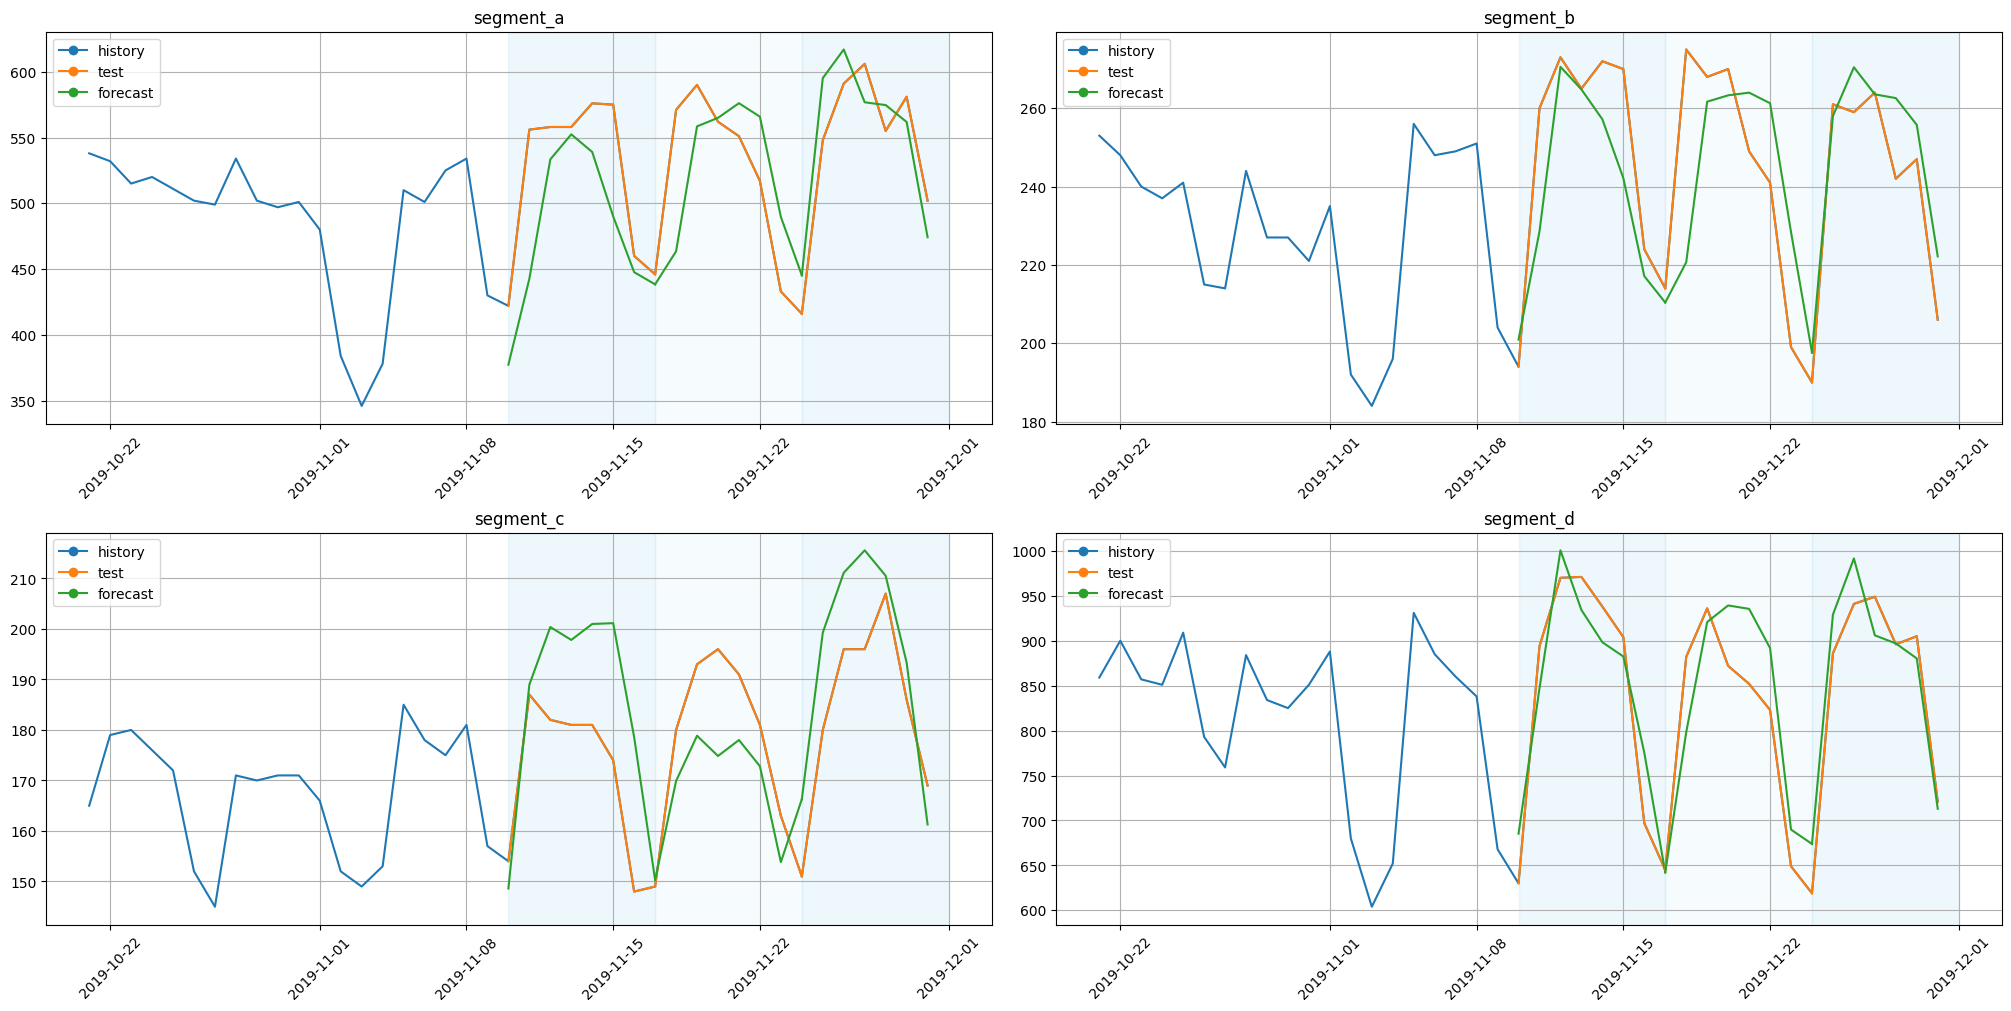

In [58]:
plot_backtest(forecast_patchtst, ts, history_len=20)

### 2.9 Chronos Model <a class="anchor" id="section_2_9"></a>

Chronos is pretrained model for zero-shot forecasting.

In [59]:
from etna.models.nn import ChronosModel

To get list of available models use `list_models`.

In [60]:
ChronosModel.list_models()

['amazon/chronos-t5-tiny',
 'amazon/chronos-t5-mini',
 'amazon/chronos-t5-small',
 'amazon/chronos-t5-base',
 'amazon/chronos-t5-large']

Let's try the smallest model.

In [61]:
set_seed()

model_chronos = ChronosModel(path_or_url="amazon/chronos-t5-tiny", encoder_length=2 * HORIZON, num_samples=10)

pipeline_chronos = Pipeline(model=model_chronos, horizon=HORIZON, transforms=[])

metrics_chronos, forecast_chronos, fold_info_chronos = pipeline_chronos.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [62]:
score = metrics_chronos["SMAPE"].mean()
print(f"Average SMAPE for Chronos tiny: {score:.3f}")

Average SMAPE for Chronos tiny: 12.999


Not good. Let's try to set `encoder_length` equals the available history of dataset. As available history length for each fold is different, so you can set `encoder_length` equals to length of the initial dataset - model will get all available history as a context.

In [63]:
dataset_length = ts.size()[0]

In [64]:
set_seed()

model_chronos = ChronosModel(path_or_url="amazon/chronos-t5-tiny", encoder_length=dataset_length, num_samples=10)

pipeline_chronos = Pipeline(model=model_chronos, horizon=HORIZON, transforms=[])

metrics_chronos, forecast_chronos, fold_info_chronos = pipeline_chronos.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [65]:
score = metrics_chronos["SMAPE"].mean()
print(f"Average SMAPE for Chronos tiny with long context: {score:.3f}")

Average SMAPE for Chronos tiny with long context: 7.094


Better. Let's get more complex model.

In [66]:
set_seed()

model_chronos = ChronosModel(path_or_url="amazon/chronos-t5-small", encoder_length=dataset_length, num_samples=10)

pipeline_chronos = Pipeline(model=model_chronos, horizon=HORIZON, transforms=[])

metrics_chronos, forecast_chronos, fold_info_chronos = pipeline_chronos.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [67]:
score = metrics_chronos["SMAPE"].mean()
print(f"Average SMAPE for Chronos small with long context: {score:.3f}")

Average SMAPE for Chronos small with long context: 5.446


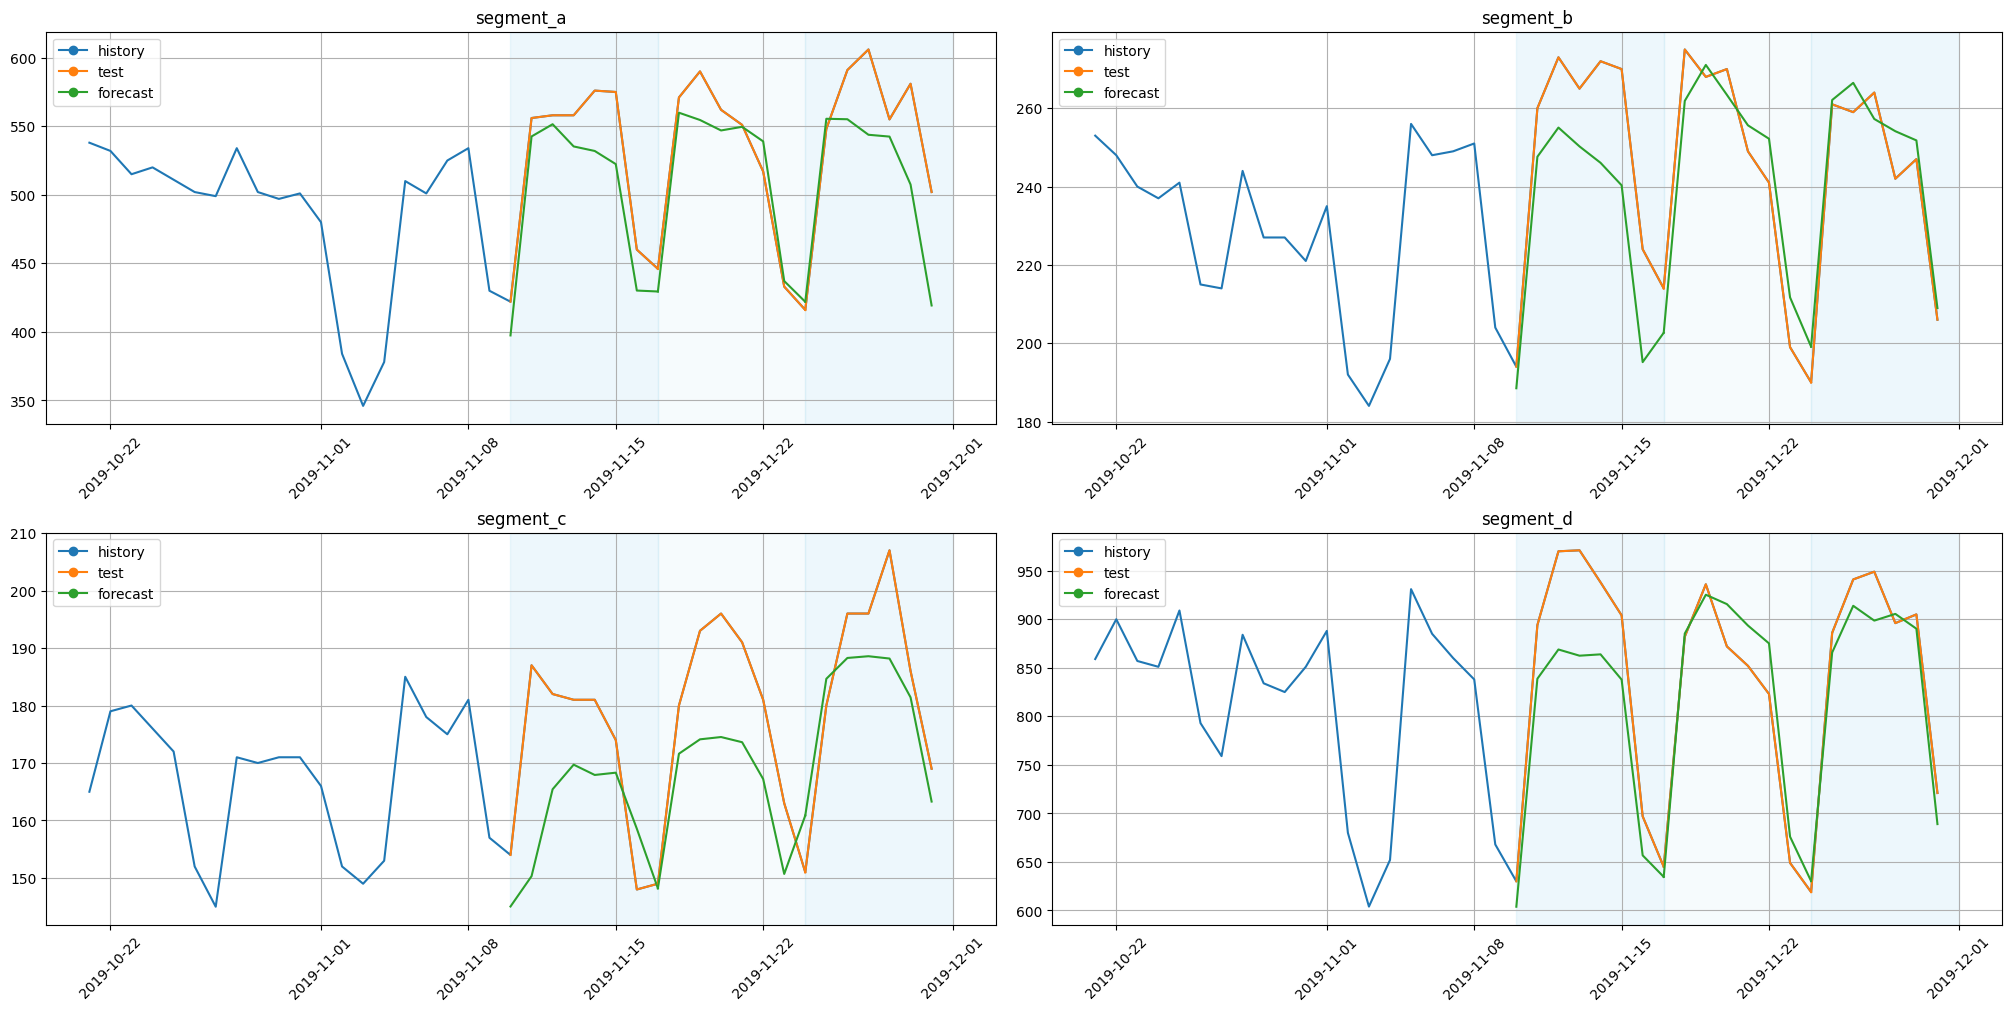

In [68]:
plot_backtest(forecast_chronos, ts, history_len=20)

We get competitive results compared to results of models, that were directly trained on forecasting dataset. For the best results you can try the most complex model `chronos-t5-large`.

### 2.10 Chronos Bolt Model <a class="anchor" id="section_2_10"></a>

Chronos Bolt is one more Chronos-like model with faster and more accurate forecasts. `ChronosBoltModel` has the same interface as `ChronosModel`.

In [69]:
from etna.models.nn import ChronosBoltModel

In [70]:
ChronosBoltModel.list_models()

['amazon/chronos-bolt-tiny',
 'amazon/chronos-bolt-mini',
 'amazon/chronos-bolt-small',
 'amazon/chronos-bolt-base']

In [71]:
set_seed()

model_chronos_bolt = ChronosBoltModel(path_or_url="amazon/chronos-bolt-small", encoder_length=dataset_length)

pipeline_chronos_bolt = Pipeline(model=model_chronos_bolt, horizon=HORIZON, transforms=[])

metrics_chronos_bolt, forecast_chronos_bolt, fold_info_chronos_bolt = pipeline_chronos_bolt.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [72]:
score = metrics_chronos_bolt["SMAPE"].mean()
print(f"Average SMAPE for Chronos Bolt small with long context: {score:.3f}")

Average SMAPE for Chronos Bolt small with long context: 5.877


### 2.11 TimesFm Model <a class="anchor" id="section_2_11"></a>

`TimesFMModel` is one more pretrained model for zero-shot forecasting. It has similar interface to `ChronosBoltModel` and `ChronosModel`.

In [73]:
from etna.models.nn import TimesFMModel

To get list of available models use `list_models`.

In [74]:
TimesFMModel.list_models()

['google/timesfm-1.0-200m-pytorch', 'google/timesfm-2.0-500m-pytorch']

Be careful. `encoder_length` needs to be a multiplier of 32.

Take 200m model.

In [75]:
set_seed()

model_timesfm = TimesFMModel(path_or_url="google/timesfm-1.0-200m-pytorch", encoder_length=64)

pipeline_timesfm = Pipeline(model=model_timesfm, horizon=HORIZON, transforms=[])

metrics_timesfm, forecast_timesfm, fold_info_timesfm = pipeline_timesfm.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [76]:
score = metrics_timesfm["SMAPE"].mean()
print(f"Average SMAPE for TimesFM 200m: {score:.3f}")

Average SMAPE for TimesFM 200m: 5.431


Models can work with exogenous features.

In [77]:
set_seed()

transforms = [
    LagTransform(in_column="target", lags=range(HORIZON, 2 * HORIZON), out_column="lag"),
]

model_timesfm = TimesFMModel(
    path_or_url="google/timesfm-1.0-200m-pytorch",
    encoder_length=64,
    time_varying_reals=[f"lag_{i}" for i in range(HORIZON, 2 * HORIZON)],
)

pipeline_timesfm = Pipeline(model=model_timesfm, horizon=HORIZON, transforms=transforms)

metrics_timesfm, forecast_timesfm, fold_info_timesfm = pipeline_timesfm.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [78]:
score = metrics_timesfm["SMAPE"].mean()
print(f"Average SMAPE for TimesFM 200m with exogenous features: {score:.3f}")

Average SMAPE for TimesFM 200m with exogenous features: 5.381


Take 500m model.

In [79]:
set_seed()

model_timesfm = TimesFMModel(
    path_or_url="google/timesfm-2.0-500m-pytorch", encoder_length=64, num_layers=50, use_positional_embedding=False
)

pipeline_timesfm = Pipeline(model=model_timesfm, horizon=HORIZON, transforms=[])

metrics_timesfm, forecast_timesfm, fold_info_timesfm = pipeline_timesfm.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


In [80]:
score = metrics_timesfm["SMAPE"].mean()
print(f"Average SMAPE for TimesFM 500m: {score:.3f}")

Average SMAPE for TimesFM 500m: 5.053


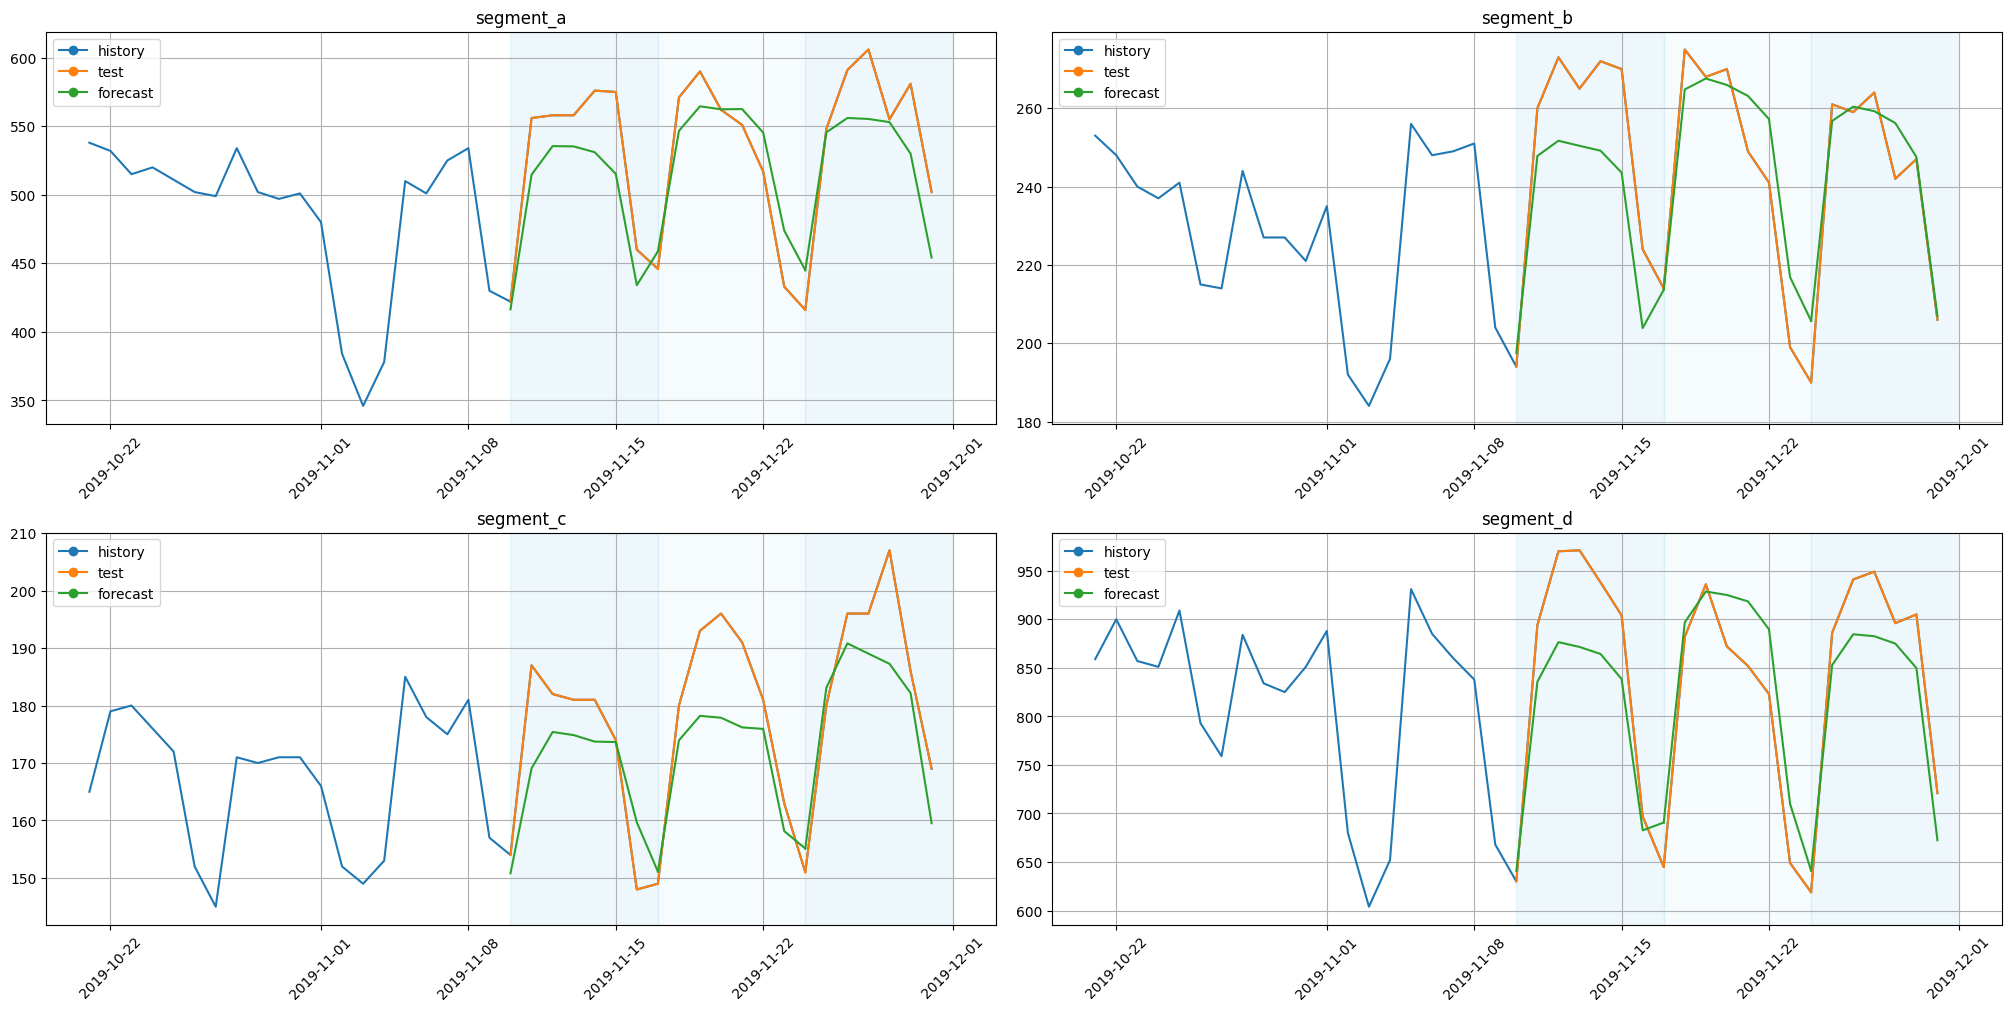

In [81]:
plot_backtest(forecast_timesfm, ts, history_len=20)